### writes 'coords'  for open boundary case

    for i in npt: 
        write x(i), y(i), z(i)   
    loop over cells (j,k):  
         write node numbers surrounding cell,  counterclockwise from lower left

In [19]:
%matplotlib inline

In [20]:
import matplotlib.pylab as plt
import numpy as np

In [21]:
ncol = 94
nrow = 63
dx = 2

npt = (ncol+1)*(nrow+1)  # number of points
ne = nrow*ncol  # number of edges
nbcell = 2*ncol + 2*nrow - 4  # number of boundary cells

In [37]:
xdum = np.arange(1, (ncol*dx+2), dx )
ydum = np.arange(1, (nrow*dx+2), dx )
# xdum = np.arange(10.125, 199.125, 2 )
# ydum = np.arange(9, 137, 2)
ydum, xdum = np.meshgrid(ydum, xdum)

zdum = np.linspace(0, 0.504, nrow+1)
zdum = np.tile(zdum, [ncol+1]).reshape([ncol+1, nrow+1])

x = np.zeros(npt + 1)
y = np.zeros(npt + 1)
z = np.zeros(npt + 1)
x[1:] = xdum.ravel()
y[1:] = ydum.ravel()
z[1:] = zdum.ravel()

# slope
(np.max(zdum) - np.min(zdum))/(np.max(ydum) - np.min(ydum))*100

0.40000000000000002

In [38]:
# (ncol+1) by (nrow+1)  -  node numbers
nodes = np.arange(1, npt+1, dtype = int).reshape([ncol+1, nrow+1])

nop = np.zeros([ncol+1, nrow+1, 4], dtype = int)
for j in range(ncol):
    for k in range(nrow):
        nop[j+1, k+1] =  nodes[j,k], nodes[j+1, k], nodes[j+1,k+1], nodes[j,k+1]

In [39]:
# dry_py.f needs an input file.  this file creates it.
f = open('coords', 'w')
f.write('{0:<13}   {1:<13}\n'.format(npt, ne))

# write x, y, z
for n in range(1, npt+1):
    f.write('{0:<13.6f} {1:<13.6f} {2:<13.6f}\n'.format(x[n],y[n],z[n])) 
    
# write node numbers  
for j in range(1, ncol+1):
    for k in range(1, nrow+1):
        n1 = nop[j, k, 0] 
        n2 = nop[j, k, 1]       
        n3 = nop[j, k, 2]        
        n4 = nop[j, k, 3] 
        f.write('{0:<10} {1:<10}  {2:<10} {3:<10}\n'.format(n1, n2, n3, n4)) 
f.close()

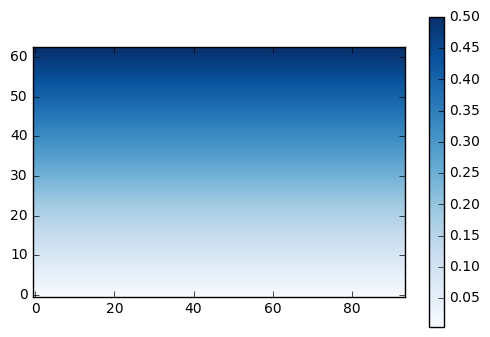

In [40]:
## get cell center values:
xcc  = np.zeros([ncol+2, nrow+2])    
ycc  = np.zeros([ncol+2, nrow+2])
zcc  = np.zeros([ncol+2, nrow+2])

for j in range(ncol+1):
    for k in range( nrow+1):
        n1 = nop[j, k, 0] 
        n2 = nop[j, k, 1]       
        n3 = nop[j, k, 2]        
        n4 = nop[j, k, 3]  
        xcc[j,k] = 0.25*(x[n1] + x[n2] + x[n3] + x[n4])  
        ycc[j,k] = 0.25*(y[n1] + y[n2] + y[n3] + y[n4])
        zcc[j,k] = 0.25*(z[n1] + z[n2] + z[n3] + z[n4])        
        
plt.imshow(zcc[1:-1, 1:-1].T, cmap = "Blues", origin = "lower")
plt.colorbar()


In [41]:
inum = np.zeros([ncol+1, nrow+1], dtype = int)
inum[1:, 1] = 1
inum[1:, -1]= 1
inum[1, 1:] = 1
inum[-1, 1:] = 1
inum[1, 1] = 2
inum[1, -1] = 2
inum[-1, -1] = 2
inum[-1, 1] = 2

In [42]:
ipos = np.zeros( [ncol+1, nrow+1, 2], dtype = int)
# bottom boundary
ipos[2:-1, 1,0] = 1
ipos[1, 1,1] = 1
ipos[-1, 1,1] = 1

# right boundary
ipos[-1, 1:-1, 0] = 2
ipos[-1, -1,1] = 2

# left boundary
ipos[1, 1:, 0] = 4

# top boundary
ipos[2:, -1,0] = 3
ipos[1, -1,1] = 3

In [43]:
itype = np.zeros([ncol+1, nrow+1, 2], dtype = int)
# bottom boundary
itype[2:-1, 1,0] = 0
itype[1, 1,1] = 0
itype[-1, 1,1] = 0

# right boundary
itype[-1, 1:-1, 0] = 1
itype[-1, -1,1] = 1

# left boundary
itype[1, 1:,0] = 1

# top boundary
itype[2:, -1,0] = 1
itype[1, -1,1] = 1
# itype[43:46,-1,0] = 4

In [44]:
# Bottom boundary is open
# plt.imshow(itype[:, :, 0].T, cmap = 'Blues', 
#            origin = 'lower', interpolation = 'none')

In [45]:
f = open('dryin.dat', 'w')
f.write('gravity     dt        tmax      xsplit      Manning n    \n')
f.write('9.806d0    0.02       2000.     100.d0       0.05d0      \n')
f.write(' epsh       beta   prate \n')  
f.write('0.0025d0    2.d0   0.07d0 \n')
f.write('xk          ainflt       binflt           tc           cappa \n')
f.write('3.9217d-4    0.5d0       2.65d-7         0.d0        0.99d0 \n')
f.write('istart     imass      ifront         print interval  \n')
f.write(' 0         1          1               100 \n')
f.write('number of boundary cell \n') 
f.write('  {0} \n'.format(nbcell))
f.write(' j    k          inum    itype             ipos \n')
# f.write(' j \t k \tinum    itype \t\t ipos')
j = 1
for k in range(1, nrow+1):
    if inum[j, k] == 2:
        f.write( '{0:<5} {1:<13} {2:<7} {3:<8} {4:<9} {5:<8} {6:<6} \n'.format(
                    j, k, inum[j, k], itype[j, k, 0], itype[j, k, 1], 
                     ipos[j, k, 0], ipos[j, k, 1]))
    else:
        f.write( '{0:<5} {1:<13} {2:<7} {3:<18} {4:<10}   \n'.format(
                     j, k, inum[j, k],  itype[j, k, 0],  ipos[j, k, 0], ))
f.close()

In [46]:
f = open('dryin.dat', 'a')
for j in range(2, ncol+1):
    if inum[j, k] == 2:
        f.write( '{0:<5} {1:<13} {2:<7} {3:<8} {4:<9} {5:<8} {6:<6} \n'.format(
                    j, k, inum[j, k], itype[j, k, 0], itype[j, k, 1], 
                     ipos[j, k, 0], ipos[j, k, 1]))
    else:
        f.write( '{0:<5} {1:<13} {2:<7} {3:<18} {4:<10}   \n'.format(
                     j, k, inum[j, k],  itype[j, k, 0],  ipos[j, k, 0], ))
f.close()

In [47]:
f = open('dryin.dat', 'a')
for k in range(nrow-1,0,-1):
    if inum[j, k] == 2:
        f.write( '{0:<5} {1:<13} {2:<7} {3:<8} {4:<9} {5:<8} {6:<6} \n'.format(
                    j, k, inum[j, k], itype[j, k, 0], itype[j, k, 1], 
                     ipos[j, k, 0], ipos[j, k, 1]))
    else:
        f.write( '{0:<5} {1:<13} {2:<7} {3:<18} {4:<10}   \n'.format(
                     j, k, inum[j, k],  itype[j, k, 0],  ipos[j, k, 0], ))

f.close()

In [48]:
f = open('dryin.dat', 'a')
for j in range(ncol-1,1,-1):
    if inum[j, k] == 2:
        f.write( '{0:<5} {1:<13} {2:<7} {3:<8} {4:<9} {5:<8} {6:<6} \n'.format(
                    j, k, inum[j, k], itype[j, k, 0], itype[j, k, 1], 
                     ipos[j, k, 0], ipos[j, k, 1]))
    else:
        f.write( '{0:<5} {1:<13} {2:<7} {3:<18} {4:<10}   \n'.format(
                     j, k, inum[j, k],  itype[j, k, 0],  ipos[j, k, 0], ))
f.close()



In [49]:
kbeg = np.ones(ncol+1, dtype = int)
kend = np.ones(ncol+1, dtype = int)*nrow

In [50]:
f = open('dryin.dat', 'a')
f.write('ncol\n')
f.write("{0}\n".format(ncol))
f.write('j     kbeg          kend \n')
for j in range(1, ncol+1):
    f.write( '{0:>5}  {1:>5} {2:>13}   \n'.format(
                j, kbeg[j],kend[k] ))
f.close()

In [51]:
f = open('dryin.dat', 'a')
f.write('h0l      u0l    v0l   \n ')
f.write('0.d0     0.0    0.0  \n ')
f.write('h0r      u0r    v0r  \n ')
f.write('0.d0     0.0    0.0  \n ')
f.close()